In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from data import *
from plotting import *
from regression import *
from utils import *

In [3]:
results_dir = 'results/accessibility/'
os.makedirs(results_dir, exist_ok=True)

In [4]:
# Load data
pcd_df = load_pcd_df()

access_df = pcd_df.dropna(subset=['Model accessibility'])
len(access_df)

993

In [5]:
model_open_categories = ['Open source', 'Open access (restricted use)', 'Open access (non-commercial)']
code_open_categories = ['Open source', 'Open access (non-commercial)', 'Open access (restricted use)']


# Add open/closed binary columns
access_df['Model open/closed'] = access_df['Model accessibility'].apply(
    lambda x: 'Open' if x in model_open_categories else 'Closed'
)

access_df['Code open/closed'] = access_df['Code accessibility'].apply(
    lambda x: 'Open' if x in code_open_categories else 'Closed'
)

/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_10339/803333015.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Model open/closed'] = access_df['Model accessibility'].apply(
/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_10339/803333015.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Code open/closed'] = access_df['Code accessibility'].apply(


In [6]:
open_df = access_df.loc[access_df['Model open/closed'] == 'Open']

In [7]:
notable = open_df.loc[(open_df['Notability criteria'].notna())]
print(len(notable))
notable.head(10)

218


,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Sparsity,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Code open/closed
1,Llama 3.1-405B,Language,Language modelling/generation,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...","SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",Open access (restricted use),https://ai.meta.com/research/publications/the-...,NaN,The Llama 3 Herd of Models,...,NaN,NaN,NaN,700.0,0,NaN,3.800000e+25,100%,Open,Open
4,Nemotron-4 340B,Language,"Language modelling/generation,Chat","Bo Adler, Niket Agarwal, Ashwath Aithal, Dong ...",Training cost,"~2e25 FLOP, so high training cost, likely >5M",Open source,https://blogs.nvidia.com/blog/nemotron-4-synth...,NaN,NVIDIA Releases Open Synthetic Data Generation...,...,NaN,NaN,NaN,700.0,0,NaN,1.800000e+25,100%,Open,Closed
9,Llama 3-70B,Language,"Chat,Language modelling/generation,Code genera...",Aaditya Singh; Aaron Grattafiori; Abhimanyu Du...,Significant use,Will almost certainly be very influential and ...,Open access (restricted use),https://ai.meta.com/blog/meta-llama-3/,NaN,Introducing Meta Llama 3: The most capable ope...,...,NaN,"""Our most efficient implementation achieves a ...",NaN,700.0,11200000,NaN,6.300000e+24,100%,Open,Open
12,Falcon-180B,Language,Language modelling,"Ebtesam Almazrouei, Hamza Alobeidli, Abdulaziz...",Training cost,"""It's currently at the top of the Hugging Face...",Open access (restricted use),https://falconllm.tii.ae/falcon-180b.html; htt...,148.0,The Falcon Series of Open Language Models,...,NaN,Estimated training compute: 3.76e24\nFLOPs at ...,NaN,400.0,1638400,NaN,3.760000e+24,100%,Open,Closed
14,Grok-1,Language,"Language modelling,Chat",NaN,SOTA improvement,"""On these benchmarks, Grok-1 displayed strong ...",Open source,"https://x.ai/model-card/, https://x.ai/blog/gr...",NaN,Announcing Grok,...,NaN,NaN,NaN,NaN,0,NaN,2.900000e+24,100%,Open,Closed
25,Qwen-72B,Language,"Chat,Code generation","Jinze Bai, Shuai Bai, Yunfei Chu, Zeyu Cui, Ka...",SOTA improvement,"SOTA on several Chinese benchmarks, with highe...",Open access (restricted use),https://huggingface.co/Qwen/Qwen-72B,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,1.300000e+24,100%,Open,Closed
26,DeepSeek-Coder-V2-236B,Language,"Code generation,Code autocompletion","Qihao Zhu, Daya Guo, Zhihong Shao, Dejian Yang...",SOTA improvement,"New SOTA on Aider, AIME 2024, and Math Odyssey...",Open access (restricted use),https://github.com/deepseek-ai/DeepSeek-Coder-V2,NaN,DeepSeek-Coder-V2: Breaking the Barrier of Clo...,...,DeepSeek-Coder-V2-236B,NaN,NaN,NaN,0,NaN,1.285200e+24,100%,Open,Closed
38,Llama 2-70B,Language,Language modelling,"Hugo Touvron, Louis Martin, Kevin Stone, Peter...","Historical significance,Significant use,Highly...",Model has been open-sourced and frequently dow...,Open access (restricted use),https://ai.meta.com/research/publications/llam...,5474.0,Llama 2: Open Foundation and Fine-Tuned Chat M...,...,NaN,8.1e23 FLOPs based on 6NC method.\nTable 2 rep...,NaN,400.0,400000,NaN,8.100000e+23,100%,Open,Closed
40,Llama 3-8B,Language,"Chat,Language modelling/generation,Code genera...",Aaditya Singh; Aaron Grattafiori; Abhimanyu Du...,Significant use,Will almost certainly be very influential and ...,Open access (restricted use),https://ai.meta.com/blog/meta-llama-3/,NaN,Introducing Meta Llama 3: The most capable ope...,...,NaN,"""Our most efficient implementation achieves a ...",NaN,700.0,11200000,NaN,7.200000e+23,100%,Open,Open
44,Yi-34B,Language,"Chat,Language modelling/generation,Translation...","Alex Young, Bei Chen, Chao Li, Chengen Huang, ...",Significant use,2nd most popular model on HuggingFace: https:/...,Open access (restricted use),https://arxiv.org/abs/2403.04652,NaN,Yi: Open Foundation Models by 01.AI,...,NaN,NaN,NaN,NaN,0,NaN,6.100000e+23,100%,Open,Closed


In [8]:
non_notable = open_df.loc[(open_df['Notability criteria'].isna())]
print(len(non_notable))
non_notable.head(10)
# 251 open but not "notable"
# some of these are clearly lower-n notable, like Qwen2, DBRX, Gemma 2, DeepSeek coder
# possible other criteria - within 1 (or 1.5 or 2) OOM training compute of frontier (1.5 OOM is ~1e24 right now)
# greater than 1000 (or 1100) on chatbot arena?

252


,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Sparsity,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Code open/closed
13,Qwen2-72B,Language,"Chat,Language modelling/generation",Qwen Team,NaN,SOTA claims are against open source models wit...,Open source,https://qwenlm.github.io/blog/qwen2/ \nhttps:/...,NaN,Hello Qwen2,...,NaN,NaN,NaN,NaN,0,NaN,3.020000e+24,100%,Open,Closed
16,DBRX,Language,"Chat,Code generation",Mosaic Research Team,NaN,NaN,Open access (restricted use),https://www.databricks.com/blog/introducing-db...,NaN,Introducing DBRX: A New State-of-the-Art Open LLM,...,DBRX,NaN,NaN,700.0,0,NaN,2.600000e+24,100%,Open,Closed
22,Gemma 2 27B,Language,"Language modelling/generation,Chat","Gemma Team, Google DeepMind",NaN,NaN,Open access (restricted use),https://storage.googleapis.com/deepmind-media/...,NaN,"Gemma 2 offers best-in-class performance, runs...",...,NaN,NaN,NaN,NaN,0,NaN,2.106000e+24,100%,Open,Closed
24,Chameleon-34B,"Multimodal,Image generation,Language,Vision","Language modelling/generation,Vision-language ...","Srinivasan Iyer, Bernie Huang, Lili Yu, Arun B...",NaN,NaN,Open access (non-commercial),https://arxiv.org/abs/2405.09818v1,NaN,Chameleon: Mixed-Modal Early-Fusion Foundation...,...,NaN,NaN,NaN,400.0,1228800,NaN,1.645357e+24,100%,Open,Closed
27,Code Llama-70B,Language,Code generation,"Baptiste Rozière, Jonas Gehring, Fabian Gloeck...",NaN,"""In our own benchmark testing, Code Llama outp...",Open access (restricted use),https://ai.meta.com/research/publications/code...,832.0,Code Llama: Open Foundation Models for Code,...,NaN,"Based on 6NC estimate, fine tuning required ar...",NaN,400.0,160000,8.100000e+23,3.000000e+22,2%,Open,Closed
28,XVERSE-65B-2,Language,"Chat,Language modelling/generation",NaN,NaN,NaN,Open access (restricted use),https://github.com/xverse-ai/XVERSE-65B/blob/m...,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,1.248000e+24,100%,Open,Open
34,TigerBot-70B,Language,"Chat,Language generation,Language modelling/ge...","Ye Chen, Wei Cai, Liangmin Wu, Xiaowei Li, Zha...",NaN,"Outperforms Llama 2:\n\n""We use 10 mainstream ...",Open access (restricted use),https://github.com/TigerResearch/TigerBot/blob...,NaN,TigerBot: An Open Multilingual Multitask LLM,...,NaN,NaN,NaN,NaN,0,8.100000e+23,8.400000e+22,8%,Open,Open
35,DeepSeek-V2,Language,"Language modelling/generation,Chat","DeepSeek-AI, Aixin Liu, Bei Feng, Bin Wang, Bi...",NaN,as of July 2024 the strongest open model in lm...,Open access (restricted use),https://arxiv.org/abs/2405.04434 \nhttps://git...,NaN,"DeepSeek-V2: A Strong, Economical, and Efficie...",...,NaN,NaN,NaN,NaN,0,NaN,1.020000e+24,100%,Open,Closed
39,DeepSeek LLM 67B,Language,Chat,"Xiao Bi, Deli Chen, Guanting Chen, Shanhuang C...",NaN,"One of the best open/Chinese models: ""Our eval...",Open access (restricted use),"https://arxiv.org/abs/2401.02954, https://gith...",NaN,DeepSeek LLM: Scaling Open-Source Language Mod...,...,NaN,NaN,NaN,NaN,0,NaN,8.040000e+23,100%,Open,Closed
49,Guanaco-65B,Language,Chat,"Tim Dettmers, Artidoro Pagnoni, Ari Holtzman, ...",NaN,"""Our best model family, which we name Guanaco,...",Open access (non-commercial),https://arxiv.org/abs/2305.14314; https://gith...,1012.0,QLoRA: Efficient Finetuning of Quantized LLMs,...,NaN,NaN,NaN,NaN,0,5.500000e+23,-8.000000e+18,-0%,Open,Open


In [9]:
print(f"Models that are not fine-tunes:  {len(open_df.loc[open_df['Base model'].isna()])}")
print(f"Models that are fine-tunes:  {len(open_df.loc[open_df['Base model'].notna()])}")
open_df.loc[open_df['Base model'].notna()].head(10)

Models that are not fine-tunes:  392
Models that are fine-tunes:  78


,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Sparsity,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Code open/closed
27,Code Llama-70B,Language,Code generation,"Baptiste Rozière, Jonas Gehring, Fabian Gloeck...",NaN,"""In our own benchmark testing, Code Llama outp...",Open access (restricted use),https://ai.meta.com/research/publications/code...,832.0,Code Llama: Open Foundation Models for Code,...,NaN,"Based on 6NC estimate, fine tuning required ar...",NaN,400.0,160000,8.100000e+23,3.000000e+22,2%,Open,Closed
34,TigerBot-70B,Language,"Chat,Language generation,Language modelling/ge...","Ye Chen, Wei Cai, Liangmin Wu, Xiaowei Li, Zha...",NaN,"Outperforms Llama 2:\n\n""We use 10 mainstream ...",Open access (restricted use),https://github.com/TigerResearch/TigerBot/blob...,NaN,TigerBot: An Open Multilingual Multitask LLM,...,NaN,NaN,NaN,NaN,0,8.100000e+23,8.400000e+22,8%,Open,Open
49,Guanaco-65B,Language,Chat,"Tim Dettmers, Artidoro Pagnoni, Ari Holtzman, ...",NaN,"""Our best model family, which we name Guanaco,...",Open access (non-commercial),https://arxiv.org/abs/2305.14314; https://gith...,1012.0,QLoRA: Efficient Finetuning of Quantized LLMs,...,NaN,NaN,NaN,NaN,0,5.500000e+23,-8.000000e+18,-0%,Open,Open
51,Code Llama-34B,Language,Code generation,"Baptiste Rozière, Jonas Gehring, Fabian Gloeck...",NaN,"SOTA for open models: ""Moreover, our largest m...",Open access (restricted use),https://ai.meta.com/research/publications/code...,832.0,Code Llama: Open Foundation Models for Code,...,NaN,NaN,NaN,400.0,0,4.080000e+23,0.000000e+00,0%,Open,Closed
56,OPT-IML (175B),Language,Language modelling,"Srinivasan Iyer, Xi Victoria Lin, Ramakanth Pa...",NaN,NaN,Open access (non-commercial),https://arxiv.org/abs/2212.12017,199.0,OPT-IML: Scaling Language Model Instruction Me...,...,NaN,NaN,NaN,400.0,51200,4.300000e+23,-2.100000e+21,-0%,Open,Closed
57,BlenderBot 3,Language,Chat,"Kurt Shuster, Jing Xu, Mojtaba Komeili, Da Ju,...",SOTA improvement,"""Human evaluations show its superiority to exi...",Open access (non-commercial),"https://arxiv.org/abs/2208.03188, https://gith...",194.0,BlenderBot 3: a deployed conversational agent ...,...,NaN,NaN,NaN,400.0,51200,4.300000e+23,-1.500000e+21,-0%,Open,Open
65,FunSearch,"Language,Search",Code generation,"Bernardino Romera-Paredes, Mohammadamin Bareka...","SOTA improvement,Historical significance",Improved SOTA for the cap set problem. Can pla...,Open source,https://www.nature.com/articles/s41586-023-069...,104.0,Mathematical discoveries from program search w...,...,FunSearch,NaN,NaN,NaN,0,7.340000e+24,-6.953000e+24,-1797%,Open,Closed
103,FinGPT-13B,Language,"Named entity recognition,Sentiment classificat...","Neng Wang, Hongyang Yang, Christina Dan Wang",SOTA improvement,SOTA for financial sentiment analysis,Open source,https://arxiv.org/abs/2310.04793; https://gith...,16.0,FinGPT: Instruction Tuning Benchmark for Open-...,...,NaN,NaN,NaN,350.0,350,1.600000e+23,-6.532488e+17,-0%,Open,Open
105,Llama Guard,Language,Chat,"Hakan Inan, Kartikeya Upasani, Jianfeng Chi, R...",SOTA improvement,"""Llama Guard, a Llama2-7b model that is instru...",Open access (restricted use),https://arxiv.org/abs/2312.06674,101.0,Llama Guard: LLM-based Input-Output Safeguard ...,...,NaN,NaN,NaN,400.0,0,8.400000e+22,7.599983e+22,47%,Open,Closed
117,WizardCoder-15.5B,Language,Code generation,"Can Xu, Qingfeng Sun, Kai Zheng, Xiubo Geng, P...",NaN,"""It surpasses all other open-source Code LLMs ...",Open access (restricted use),https://arxiv.org/abs/2306.08568,304.0,WizardCoder: Empowering Code Large Language Mo...,...,NaN,NaN,NaN,NaN,0,8.460000e+22,2.738050e+22,24%,Open,Open


In [10]:
notable_finetunes = open_df.loc[(open_df['Base model'].notna()) & (open_df['Notability criteria'].notna())]
print(len(notable_finetunes))
notable_finetunes[['System', 'Notability criteria']]
# 33 notable, fine-tuned open models

32


,System,Notability criteria
57,BlenderBot 3,SOTA improvement
65,FunSearch,"SOTA improvement,Historical significance"
103,FinGPT-13B,SOTA improvement
105,Llama Guard,SOTA improvement
167,Volcano 13B,SOTA improvement
169,LLaVA 1.5,SOTA improvement
192,Flan-T5 11B,Highly cited
209,CogVLM,SOTA improvement
255,VideoMAE V2,SOTA improvement
263,Segment Anything Model,Highly cited


In [11]:
open_df.groupby('Domain').size().sort_values(ascending=False)

Domain
Language                                                    302
Biology                                                      44
Vision                                                       40
Multimodal,Language,Vision                                   13
Image generation                                             11
Speech                                                        9
Games                                                         4
Vision,Image generation                                       4
Audio                                                         3
Robotics                                                      3
Earth science                                                 3
Multimodal,Vision,Language                                    3
Language,Biology                                              2
Vision,Language                                               2
Video                                                         2
Language,Vision,Multimodal       

# Model Accessibility Charts

In [12]:
# Add year column
access_df['Year'] = pd.to_datetime(access_df['Publication date']).dt.year


/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_10339/3747043736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Year'] = pd.to_datetime(access_df['Publication date']).dt.year


In [13]:
# Input -  model counts, grouped by accessibility and by year
# Output - same dataframe with cumulative counts for status

def get_cumulative_counts(counts):
    
    counts['Cumulative for status'] = counts.groupby('Model accessibility')['Count'].cumsum()
    
    # Pivot the access counts table to get counts for every status and every year
    # This will have many NaN values because not every year has a model of every status
    counts_wide = counts.pivot(index='Year', columns='Model accessibility', values='Cumulative for status')
    all_years = pd.Series(range(counts_wide.index.min(), counts_wide.index.max() + 1))
    

    # Fill NaN values with 0. This ensures that the cumulative count does not get dropped in individual years 
    # where there are no models with a given status
    counts_wide_filled = counts_wide.reindex(all_years).ffill().fillna(0)
    counts_wide_filled = counts_wide_filled.reset_index(names=["Year"])
    

    # Unpivot to get cumulative totals
    counts_filled = (counts_wide_filled.melt(id_vars='Year', 
                                         var_name='Model accessibility', 
                                         value_name='Cumulative for status')
                                   .reset_index(drop=True))

    # sort from closed to open
    sort_order = ['Unreleased', 'Hosted access (no API)', 'API access', 'Open access (non-commercial)', 'Open access (restricted use)', 'Open source']
    counts_filled['Category_sorted'] = pd.Categorical(counts_filled['Model accessibility'], categories=sort_order, ordered=True)
    counts_filled = counts_filled.sort_values(['Category_sorted', 'Year'])

    return counts_filled

In [14]:
# Get counts of all models by year and model accessibility
# Only include 2015 and later because older models are rare
access_counts = access_df.loc[access_df['Year'] >= 2015].groupby(['Year', 'Model accessibility']).size().reset_index(name='Count')

cumulative_access_counts = get_cumulative_counts(access_counts)

# Cumulative area chart
fig = px.area(cumulative_access_counts, x='Year', y='Cumulative for status', color='Model accessibility', line_group='Model accessibility',
              labels={'Cumulative for status': 'Cumulative Count', 'Year': 'Year'},
              title='Model count by accessibility over time')

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)

# save_plot(fig, results_dir, f'cumulative_model_count_by_accessibility')

fig.show()

Commentary: around half of models are unreleased as of 2024, but the proportion has been shrinking over time. Before 2018 or so, releasing model weights was rare (academic projects often shared training code, but not weights)

In [15]:
notable_df = access_df.loc[(access_df['Notability criteria'].notna())]

# Get counts of notable models by year and model accessibility
# Only include 2015 and later because older models are rare
notable_counts = notable_df.loc[access_df['Year'] >= 2015].groupby(['Year', 'Model accessibility']).size().reset_index(name='Count')

cumulative_notable_counts = get_cumulative_counts(notable_counts)

In [16]:
# Input -  model counts, grouped by accessibility and by year
# Output - same dataframe with cumulative counts for status, cumulative total across all statuses, and proportion
def normalize_counts(access_counts):
    
    # Get df with total models per year, and cumulative totals
    total_counts = access_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
    total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
    
    # Pivot the access counts table to get counts for every status and every year
    # This will have many NaN values because not every year has a model of every status
    access_counts_wide = access_counts.pivot(index='Year', columns='Model accessibility', values='Cumulative for status')
    all_years = pd.Series(range(access_counts_wide.index.min(), access_counts_wide.index.max() + 1))

    # Fill in the NaN values
    access_counts_wide_filled = access_counts_wide.reindex(all_years).ffill().fillna(0)
    access_counts_wide_filled = access_counts_wide_filled.reset_index(names=["Year"])
    
    # Unpivot
    access_counts_filled = (access_counts_wide_filled.melt(id_vars='Year', 
                                     var_name='Model accessibility', 
                                     value_name='Cumulative for status')
                               .reset_index(drop=True))
    
    # Join with total counts df to get the cumulative totals
    normalized_counts = pd.merge(access_counts_filled, total_counts, on='Year')
    
    # Divide annual counts by cumulative counts to find cumulative proportions by year
    normalized_counts['proportion'] = normalized_counts['Cumulative for status'] / normalized_counts['Cumulative Total']
    
    # Sort using custom order
    sort_order = ['Unreleased', 'Hosted access (no API)', 'API access', 'Open access (non-commercial)', 'Open access (restricted use)', 'Open source']
    normalized_counts['Category_sorted'] = pd.Categorical(normalized_counts['Model accessibility'], categories=sort_order, ordered=True)
    normalized_counts = normalized_counts.sort_values(['Category_sorted', 'Year'])
    
    return normalized_counts

In [17]:
normalized_counts_total = normalize_counts(access_counts)
normalized_counts_notable = normalize_counts(notable_counts)

In [18]:
# Create a 1x2 subplot
fig = make_subplots(rows=1, cols=2, subplot_titles=('Cumulative count',
                                                    'Cumulative proportion'))

# Define a consistent color palette
color_palette = {
    'Unreleased': '#d62728',
    'Hosted access (no API)': '#ff7f0e',
    'API access': '#8c564b',
    'Open access (non-commercial)': '#9467bd',
    'Open access (restricted use)': '#1f77b4',
    'Open source': '#2ca02c'
}

# Cumulative area chart
for accessibility in cumulative_notable_counts['Model accessibility'].unique():
    fig.add_trace(
        go.Scatter(x=cumulative_notable_counts[cumulative_notable_counts['Model accessibility'] == accessibility]['Year'], 
                y=cumulative_notable_counts[cumulative_notable_counts['Model accessibility'] == accessibility]['Cumulative for status'], 
                hoverinfo='x+y',
                stackgroup='one',
                mode='lines',
                name=accessibility,
                line=dict(color=color_palette[accessibility])),
        row=1, col=1
    )

# Normalized area chart
for accessibility in normalized_counts_notable['Model accessibility'].unique():
    fig.add_trace(
        go.Scatter(x=normalized_counts_notable[normalized_counts_notable['Model accessibility'] == accessibility]['Year'], 
                y=normalized_counts_notable[normalized_counts_notable['Model accessibility'] == accessibility]['proportion'], 
                hoverinfo='x+y',
                stackgroup='one',
                mode='lines',
                name=accessibility,
                line=dict(color=color_palette[accessibility]),
                showlegend=False),
        row=1, col=2
    )

# Update layout
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title_text='Notable models accessibility over time',
    showlegend=True
)

# Update x and y axes
fig.update_xaxes(title_text='Year', range=[2018, 2024], row=1, col=1)
fig.update_xaxes(title_text='Year', range=[2018, 2024], row=1, col=2)
fig.update_yaxes(title_text='Cumulative count', row=1, col=1)
fig.update_yaxes(title_text='Cumulative proportion', range=[0, 1], row=1, col=2)

save_plot(fig, results_dir, f'cumulative_model_count_by_accessibility')

fig.show()

This chart shows the proportions over time more clearly - open weights have never been very rare (at least 10%). But open models have become much more common over time, making up around half of models today. The large majority of those are permissively licensed ("Open source") even today but open with restrictions has become more common over time.

In [19]:
fig = px.area(normalized_counts_notable, x='Year', y='proportion', color='Model accessibility', line_group='Model accessibility',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative proportion of notable models by accessibility over time')

fig.update_yaxes(range=[0, 1])
fig.update_xaxes(range=[2018, 2024])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)

fig.show()

In [20]:
fig = px.area(normalized_counts_total, x='Year', y='proportion', color='Model accessibility', line_group='Model accessibility',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative proportion of all models by accessibility over time')

fig.update_yaxes(range=[0, 1])
fig.update_xaxes(range=[2018, 2024])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)
# save_plot(fig, results_dir, f'proportion_by_accessibility')
fig.show()

# Code vs Model Accessibility

In [21]:
print(f"There are {len(access_df[access_df['Code accessibility'].isna()])} models with marked code access and unmarked code access")

There are 116 models with marked code access and unmarked code access


In [22]:
# filter for code accessibility
code_df = access_df.dropna(subset=['Code accessibility'])

In [23]:
code_df.head(8)

,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Code open/closed,Year
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",Gemini Team,"SOTA improvement,Training cost",""" Evaluation on a broad range of benchmarks sh...",Hosted access (no API),https://storage.googleapis.com/deepmind-media/...,633.0,Gemini: A Family of Highly Capable Multimodal ...,...,NaN,NaN,192.0,10560000,NaN,5.000000e+25,100%,Closed,Closed,2023
1,Llama 3.1-405B,Language,Language modelling/generation,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...","SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",Open access (restricted use),https://ai.meta.com/research/publications/the-...,NaN,The Llama 3 Herd of Models,...,NaN,NaN,700.0,0,NaN,3.800000e+25,100%,Open,Open,2024
2,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,"OpenAI, Josh Achiam, Steven Adler, Sandhini Ag...","Highly cited,SOTA improvement,Training cost","See the paper, p.1: ""On a suite of traditional...",API access,https://arxiv.org/abs/2303.08774,5290.0,GPT-4 Technical Report,...,(Speculative) SemiAnalysis conjectures that GP...,NaN,400.0,10000000,NaN,2.100000e+25,100%,Closed,Closed,2023
3,Mistral Large,Language,Chat,NaN,Training cost,~$20M training cost: https://www.wsj.com/tech/...,API access,https://mistral.ai/news/mistral-large/,NaN,"Mistral Large, our new flagship model",...,NaN,NaN,350.0,0,NaN,2.000000e+25,100%,Closed,Closed,2024
4,Nemotron-4 340B,Language,"Language modelling/generation,Chat","Bo Adler, Niket Agarwal, Ashwath Aithal, Dong ...",Training cost,"~2e25 FLOP, so high training cost, likely >5M",Open source,https://blogs.nvidia.com/blog/nemotron-4-synth...,NaN,NVIDIA Releases Open Synthetic Data Generation...,...,NaN,NaN,700.0,0,NaN,1.800000e+25,100%,Open,Closed,2024
5,MegaScale (Production),Language,Language modelling/generation,"Ziheng Jiang, Haibin Lin, Yinmin Zhong, Qi Hua...",SOTA improvement,Improves SOTA in FLOP utilization for distribu...,Unreleased,https://arxiv.org/abs/2402.15627,10.0,MegaScale: Scaling Large Language Model Traini...,...,NaN,NaN,400.0,4915200,NaN,1.200000e+25,100%,Closed,Closed,2024
6,Inflection-2,Language,"Language modelling,Language modelling/generati...",NaN,"Significant use,Training cost",Inflection-2 either already powers Pi or soon ...,Hosted access (no API),https://inflection.ai/inflection-2,NaN,Inflection-2: The Next Step Up,...,NaN,NaN,700.0,3500000,NaN,1.001000e+25,100%,Closed,Closed,2023
7,Inflection-2.5,Language,Chat,NaN,Significant use,one million daily users; six million monthly,Hosted access (no API),https://inflection.ai/inflection-2-5,NaN,Inflection-2.5: meet the world's best personal AI,...,NaN,NaN,700.0,0,NaN,1.000100e+25,100%,Closed,Closed,2024


In [24]:
model_counts = code_df.groupby('Model accessibility').size().reset_index(name='Counts')
model_counts

,Model accessibility,Counts
0,API access,36
1,Hosted access (no API),21
2,Open access (non-commercial),76
3,Open access (restricted use),55
4,Open source,269
5,Unreleased,420


In [25]:
code_counts = code_df.groupby('Code accessibility').size().reset_index(name='Counts')
code_counts

,Code accessibility,Counts
0,Open access (non-commercial),77
1,Open access (restricted use),8
2,Open source,339
3,Unreleased,453


In [27]:
grouped_counts = code_df.groupby(['Model accessibility', 'Code accessibility']).size().reset_index(name='Counts')
pivoted = grouped_counts.pivot(index='Model accessibility', columns='Code accessibility', values='Counts').fillna(0)

# code access against model access
pivoted

Code accessibility,Open access (non-commercial),Open access (restricted use),Open source,Unreleased
Model accessibility,,,,
API access,0.0,0.0,0.0,36.0
Hosted access (no API),1.0,0.0,1.0,19.0
Open access (non-commercial),38.0,1.0,16.0,21.0
Open access (restricted use),0.0,5.0,14.0,36.0
Open source,2.0,1.0,199.0,67.0
Unreleased,36.0,1.0,109.0,274.0


In [28]:
model_code_counts = code_df.groupby(['Model open/closed', 'Code open/closed']).size().reset_index(name='Counts')
model_code_counts = model_code_counts.pivot(index='Model open/closed', columns='Code open/closed', values='Counts')

# code open vs model open
model_code_counts

Code open/closed,Closed,Open
Model open/closed,,
Closed,329,148
Open,124,276


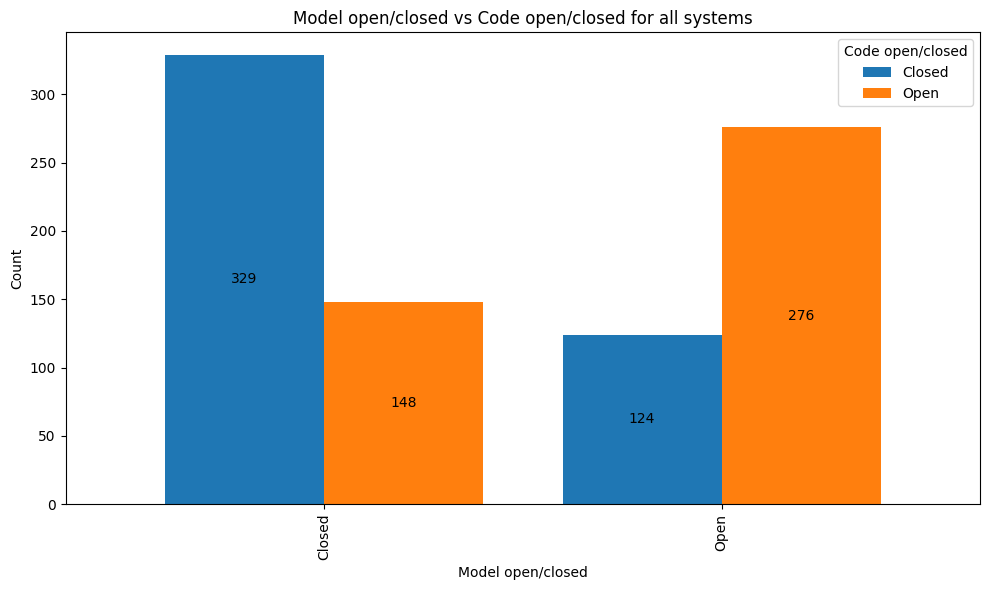

In [29]:
ax = model_code_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Customize the chart
plt.title('Model open/closed vs Code open/closed for all systems')
plt.ylabel('Count')


# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

In [43]:
import plotly.graph_objects as go

# Data
z = [[329, 148],
     [124, 275]]

fig = go.Figure(data=go.Heatmap(
    z=model_code_counts.values,
    x=model_code_counts.columns,
    y=model_code_counts.index,
    hoverongaps = False,
    text=z,
    texttemplate="%{text}",
    textfont={"size":20},
    colorscale='Blues'
))

fig.update_layout(
    autosize=False,
    width=400,
    height=300,
    title='Model and training code accessibility',
    xaxis_title='Code open/closed',
    yaxis_title='Model open/closed'
)

save_plot(fig, results_dir, f'model_code_accessibility_heatmap')

fig.show()

Model openness and code openness are reasonably correlated - most closed-weight models have closed code, while somewhat more open models have open code than closed code. This also applies across the other direction - most closed code models have closed weights, most open code models have open weights.

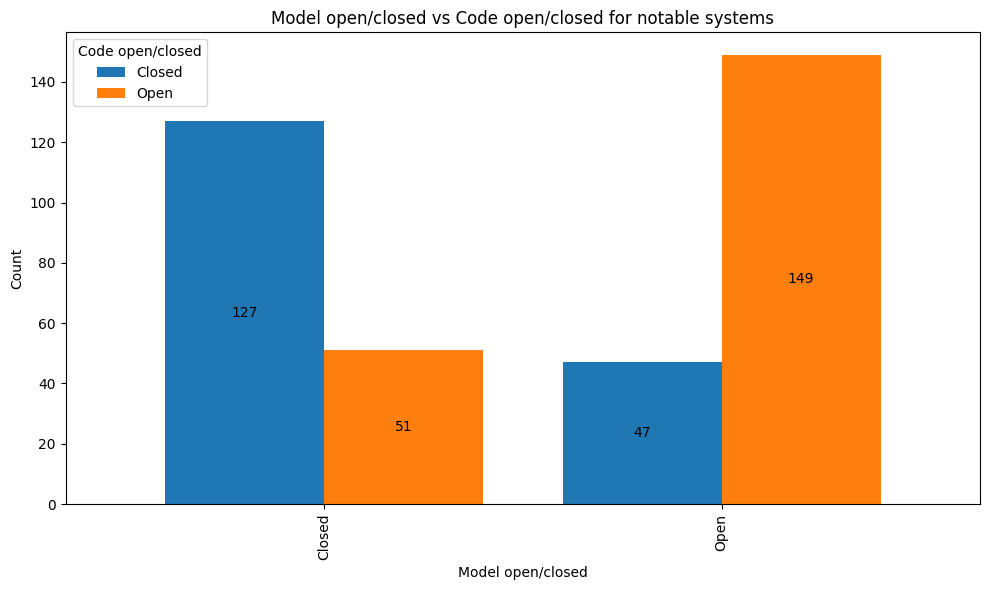

In [31]:
notable_code_df = code_df.loc[(code_df['Notability criteria'].notna())]

notable_open_counts = notable_code_df.groupby(['Model open/closed', 'Code open/closed']).size().reset_index(name='Counts')
notable_open_counts = notable_open_counts.pivot(index='Model open/closed', columns='Code open/closed', values='Counts')

ax = notable_open_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

plt.title('Model open/closed vs Code open/closed for notable systems')
plt.ylabel('Count')

for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.tight_layout()
plt.show()

In [32]:
open_counts = code_df.loc[code_df['Year'] >= 2015].groupby(['Year', 'Model open/closed', 'Code open/closed']).size().reset_index(name='Count')

open_counts['Cumulative'] = open_counts.groupby(['Model open/closed', 'Code open/closed'])['Count'].cumsum()

open_counts.head(10)

,Year,Model open/closed,Code open/closed,Count,Cumulative
0,2015,Closed,Closed,5,5
1,2015,Closed,Open,1,1
2,2015,Open,Open,2,2
3,2016,Closed,Closed,18,23
4,2016,Closed,Open,2,3
5,2016,Open,Open,2,4
6,2017,Closed,Closed,15,38
7,2017,Closed,Open,13,16
8,2017,Open,Open,1,5
9,2018,Closed,Closed,32,70


In [33]:
total_counts = open_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
total_counts

,Year,Yearly Total,Cumulative Total
0,2015,8,8
1,2016,22,30
2,2017,29,59
3,2018,65,124
4,2019,138,262
5,2020,91,353
6,2021,137,490
7,2022,117,607
8,2023,188,795
9,2024,63,858


In [34]:
open_counts_wide = open_counts.pivot(index='Year', columns=['Model open/closed', 'Code open/closed'], values='Count')
open_counts_wide = open_counts_wide.fillna(0).reset_index()
open_counts_wide

Model open/closed  Year Closed        Open       
Code open/closed        Closed  Open  Open Closed
0                  2015    5.0   1.0   2.0    0.0
1                  2016   18.0   2.0   2.0    0.0
2                  2017   15.0  13.0   1.0    0.0
3                  2018   32.0  11.0  21.0    1.0
4                  2019   56.0  36.0  37.0    9.0
5                  2020   40.0  15.0  30.0    6.0
6                  2021   49.0  30.0  51.0    7.0
7                  2022   30.0  21.0  48.0   18.0
8                  2023   47.0  11.0  70.0   60.0
9                  2024   22.0   4.0  14.0   23.0

In [35]:
print(open_counts_wide.columns.to_list())
print(open_counts_wide.index.names)

[('Year', ''), ('Closed', 'Closed'), ('Closed', 'Open'), ('Open', 'Open'), ('Open', 'Closed')]
[None]


In [36]:
# Convert pivoted multi-columns to single columns with clear names
new_columns = ['Year'] + [f'Model {outer} Code {inner}' for outer, inner in open_counts_wide.columns[1:]]
open_counts_wide.columns = new_columns

open_counts_wide

,Year,Model Closed Code Closed,Model Closed Code Open,Model Open Code Open,Model Open Code Closed
0,2015,5.0,1.0,2.0,0.0
1,2016,18.0,2.0,2.0,0.0
2,2017,15.0,13.0,1.0,0.0
3,2018,32.0,11.0,21.0,1.0
4,2019,56.0,36.0,37.0,9.0
5,2020,40.0,15.0,30.0,6.0
6,2021,49.0,30.0,51.0,7.0
7,2022,30.0,21.0,48.0,18.0
8,2023,47.0,11.0,70.0,60.0
9,2024,22.0,4.0,14.0,23.0


In [37]:
# unpivot table to get the count of each 2x2 value for each year
open_counts_filled = (open_counts_wide.melt(id_vars=['Year'], 
                                            var_name='Category',
                                            value_name='Count')
                                      .reset_index(drop=True))

open_counts_filled.head(20)

,Year,Category,Count
0,2015,Model Closed Code Closed,5.0
1,2016,Model Closed Code Closed,18.0
2,2017,Model Closed Code Closed,15.0
3,2018,Model Closed Code Closed,32.0
4,2019,Model Closed Code Closed,56.0
5,2020,Model Closed Code Closed,40.0
6,2021,Model Closed Code Closed,49.0
7,2022,Model Closed Code Closed,30.0
8,2023,Model Closed Code Closed,47.0
9,2024,Model Closed Code Closed,22.0


In [38]:
open_counts_filled['Cumulative for Category'] = open_counts_filled.groupby('Category')['Count'].cumsum()

with_totals = pd.merge(open_counts_filled, total_counts, on="Year")
with_totals['proportion'] = with_totals['Cumulative for Category'] / with_totals['Cumulative Total']
with_totals.head(20)

,Year,Category,Count,Cumulative for Category,Yearly Total,Cumulative Total,proportion
0,2015,Model Closed Code Closed,5.0,5.0,8,8,0.625000
1,2016,Model Closed Code Closed,18.0,23.0,22,30,0.766667
2,2017,Model Closed Code Closed,15.0,38.0,29,59,0.644068
3,2018,Model Closed Code Closed,32.0,70.0,65,124,0.564516
4,2019,Model Closed Code Closed,56.0,126.0,138,262,0.480916
5,2020,Model Closed Code Closed,40.0,166.0,91,353,0.470255
6,2021,Model Closed Code Closed,49.0,215.0,137,490,0.438776
7,2022,Model Closed Code Closed,30.0,245.0,117,607,0.403624
8,2023,Model Closed Code Closed,47.0,292.0,188,795,0.367296
9,2024,Model Closed Code Closed,22.0,314.0,63,858,0.365967


In [40]:
# sort using custom order
sort_order = ['Model Closed Code Closed', 'Model Closed Code Open', 'Model Open Code Closed', 'Model Open Code Open']

with_totals['Category_sorted'] = pd.Categorical(with_totals['Category'], categories=sort_order, ordered=True)
with_totals = with_totals.sort_values('Category_sorted')


colors = ['crimson', 'tomato', 'blue', 'dodgerblue']
fig = px.area(with_totals, x='Year', y='proportion', color='Category', line_group='Category',
              labels={'proportion': 'Proportion', 'Year': 'Year', 'Category': 'Accessibility'},
              title='Model and training code accessibility over time', color_discrete_sequence=colors)

fig.update_yaxes(range=[0, 1])
fig.update_xaxes(range=[2018, 2024])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)

save_plot(fig, results_dir, f'model_code_accessibility_over_time')

fig.show()

This chart shows the proportions across the four categories of model open/closed and code open/closed. The blue areas are open-weight models and the red areas are closed-weight, while the lighter colors are code open and the darker colors are code closed. Among open-weight models, code closed has become more common. Intuitively, this is consistent with the rise of the commercial open-source industry, which releases model weights but does not wish to give competitors the ability to recreate their base models.

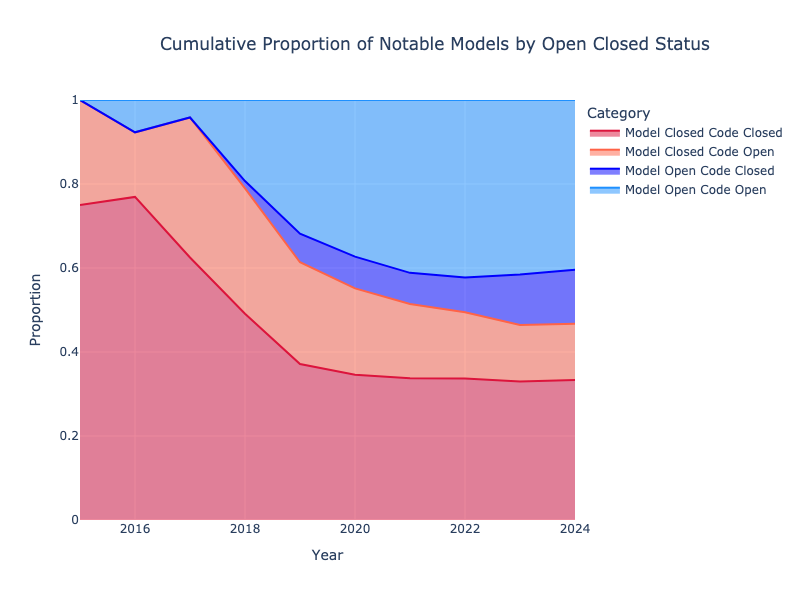

In [ ]:
# repeat the above code but with notable models only
open_counts = notable_code_df.loc[code_df['Year'] >= 2015].groupby(['Year', 'Model open/closed', 'Code open/closed']).size().reset_index(name='Count')

open_counts['Cumulative'] = open_counts.groupby(['Model open/closed', 'Code open/closed'])['Count'].cumsum()

total_counts = open_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()

open_counts_wide = open_counts.pivot(index='Year', columns=['Model open/closed', 'Code open/closed'], values='Count')
open_counts_wide = open_counts_wide.fillna(0).reset_index()

# Convert pivoted multi-columns to single columns with clear names
new_columns = ['Year'] + [f'Model {outer} Code {inner}' for outer, inner in open_counts_wide.columns[1:]]
open_counts_wide.columns = new_columns

# unpivot table to get the count of each 2x2 value for each year
open_counts_filled = (open_counts_wide.melt(id_vars=['Year'], 
                                            var_name='Category',
                                            value_name='Count')
                                      .reset_index(drop=True))

open_counts_filled['Cumulative for Category'] = open_counts_filled.groupby('Category')['Count'].cumsum()

with_totals = pd.merge(open_counts_filled, total_counts, on="Year")
with_totals['proportion'] = with_totals['Cumulative for Category'] / with_totals['Cumulative Total']

# sort using custom order
sort_order = ['Model Closed Code Closed', 'Model Closed Code Open', 'Model Open Code Closed', 'Model Open Code Open']

with_totals['Category_sorted'] = pd.Categorical(with_totals['Category'], categories=sort_order, ordered=True)
with_totals = with_totals.sort_values('Category_sorted')


colors = ['crimson', 'tomato', 'blue', 'dodgerblue']
fig = px.area(with_totals, x='Year', y='proportion', color='Category', line_group='Category',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative Proportion of Notable Models by Open Closed Status', color_discrete_sequence=colors)

fig.update_yaxes(range=[0, 1])
fig.update_xaxes(range=[2018, 2024])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)
fig